# 1. Load and Preprocess Data

In [207]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from tqdm import tqdm
import pandas as pd
import numpy as np
import string
import random
import torch
import math
import os
import re

In [208]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = 82
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if device == 'cuda':
    torch.cuda.manual_seed_all(seed)

In [209]:
df = pd.read_csv('/kaggle/input/normal-royal/normal-royal - nice(1).csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.rename(columns={"Normal Khmer (សាមញ្ញ)": "normal", "Royal Khmer (រាជស័ព្ទ)": "royal"}, inplace=True)
df.dropna(inplace=True)
df

,normal,royal
0,លោកបានដើរកាត់តាមឆ្នេរសមុទ្រ។,ព្រះអង្គស្តេចយាងកាត់តាមឆ្នេរសមុទ្រ។
1,លោកបានទៅដល់កោះមួយ។,ព្រះអង្គស្តេចយាងទៅដល់កោះមួយ។
2,វាជាផ្លូវចេញចូលរបស់ស្ដេចនាគ។,វាជាព្រះរាជមហាវិថីយាងចេញចូលនៃព្រះមហាក្សត្រនាគ។
3,ស្ដេចនាគចេញមកលេងកម្សាន្ត។,ព្រះមហាក្សត្រនាគស្តេចយាងមកកម្សាន្តព្រះរាជហឫទ័យ។
4,ទេវតានឹងចូលមកជួបសំពះព្រះពុទ្ធ។,ទេវតានឹងចូលមកជួបថ្វាយបង្គំScopeព្រះពុទ្ធអង្គ។
...,...,...
790,ស្ដេចឱ្យគេឆ្លាក់រូបសត្វហង្សលើដំបូលវាំង។,ព្រះមហាក្សត្រត្រាស់បង្គាប់ឱ្យឆ្លាក់រូបសត្វហង្ស...
791,ស្ដេចចូលចិត្តដើរលេងក្នុងព្រៃភ្នំ។,ព្រះមហាក្សត្រសព្វព្រះរាជហឫទ័យ យាងកម្សាន្តតាមតំ...
792,ស្ដេចឱ្យគេធ្វើឆត្រធំៗសម្រាប់ការពារកម្ដៅថ្ងៃ។,ព្រះមហាក្សត្រត្រាស់បង្គាប់ឱ្យរៀបចំព្រះក្លស់សម្...
793,ស្ដេចមានចិត្តចង់ជួយខ្មែរឱ្យរស់បានយូរ។,ព្រះមហាក្សត្រមានព្រះរាជបំណងចង់ឱ្យកូនចៅខ្មែរមាន...


In [210]:
import re
import string

unwanted_chars = ['\u200b','\u200c','\u200d','\ufeff','៙','៚','៖','ៗ','៛','។']

khmer_punct = ''

def clean_text(text):
    text = ''.join(c for c in text if c not in unwanted_chars)
    text = re.sub(r'[A-Za-z0-9]+', '', text)
    allowed_chars = string.ascii_letters + string.digits
    text = ''.join(c for c in text if c not in string.punctuation)
    text = re.sub(r'[^\u1780-\u17FF\u17E0-\u17E9\s' + khmer_punct + ']', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

df['normal'] = df['normal'].apply(clean_text)
df['royal'] = df['royal'].apply(clean_text)

In [211]:
def sentence_to_char_indices(sentence, vocab):
    chars = list(sentence)
    return [vocab["<sos>"]] + [vocab.get(c, vocab["<unk>"]) for c in chars] + [vocab["<eos>"]]

df['input_ids'] = df['normal'].apply(lambda s: sentence_to_char_indices(s, stoi))
df['target_ids'] = df['royal'].apply(lambda s: sentence_to_char_indices(s, stoi))

In [212]:
df

,normal,royal,input_ids,target_ids
0,លោកបានដើរកាត់តាមឆ្នេរសមុទ្រ,ព្រះអង្គស្តេចយាងកាត់តាមឆ្នេរសមុទ្រ,"[92, 28, 65, 1, 21, 51, 20, 11, 59, 27, 1, 51,...","[92, 23, 79, 27, 68, 33, 5, 79, 3, 30, 79, 16,..."
1,លោកបានទៅដល់កោះមួយ,ព្រះអង្គស្តេចយាងទៅដល់កោះមួយ,"[92, 28, 65, 1, 21, 51, 20, 18, 66, 11, 28, 72...","[92, 23, 79, 27, 68, 33, 5, 79, 3, 30, 79, 16,..."
2,វាជាផ្លូវចេញចូលរបស់ស្ដេចនាគ,វាជាព្រះរាជមហាវិថីយាងចេញចូលនៃព្រះមហាក្សត្រនាគ,"[92, 29, 51, 8, 51, 22, 79, 28, 57, 29, 6, 62,...","[92, 29, 51, 8, 51, 23, 79, 27, 68, 27, 51, 8,..."
3,ស្ដេចនាគចេញមកលេងកម្សាន្ត,ព្រះមហាក្សត្រនាគស្តេចយាងមកកម្សាន្តព្រះរាជហឫទ័យ,"[92, 30, 79, 11, 62, 6, 20, 51, 3, 6, 62, 10, ...","[92, 23, 79, 27, 68, 25, 31, 51, 1, 79, 30, 16..."
4,ទេវតានឹងចូលមកជួបសំពះព្រះពុទ្ធ,ទេវតានឹងចូលមកជួបថ្វាយបង្គំព្រះពុទ្ធអង្គ,"[92, 18, 62, 29, 16, 51, 20, 54, 5, 6, 57, 28,...","[92, 18, 62, 29, 16, 51, 20, 54, 5, 6, 57, 28,..."
...,...,...,...,...
790,ស្ដេចឱ្យគេឆ្លាក់រូបសត្វហង្សលើដំបូលវាំង,ព្រះមហាក្សត្រត្រាស់បង្គាប់ឱ្យឆ្លាក់រូបសត្វហង្ស...,"[92, 30, 79, 11, 62, 6, 47, 79, 26, 3, 62, 7, ...","[92, 23, 79, 27, 68, 25, 31, 51, 1, 79, 30, 16..."
791,ស្ដេចចូលចិត្តដើរលេងក្នុងព្រៃភ្នំ,ព្រះមហាក្សត្រសព្វព្រះរាជហឫទ័យ យាងកម្សាន្តតាមតំ...,"[92, 30, 79, 11, 62, 6, 6, 57, 28, 6, 52, 16, ...","[92, 23, 79, 27, 68, 25, 31, 51, 1, 79, 30, 16..."
792,ស្ដេចឱ្យគេធ្វើឆត្រធំសម្រាប់ការពារកម្ដៅថ្ងៃ,ព្រះមហាក្សត្រត្រាស់បង្គាប់ឱ្យរៀបចំព្រះក្លស់សម្...,"[92, 30, 79, 11, 62, 6, 47, 79, 26, 3, 62, 19,...","[92, 23, 79, 27, 68, 25, 31, 51, 1, 79, 30, 16..."
793,ស្ដេចមានចិត្តចង់ជួយខ្មែរឱ្យរស់បានយូរ,ព្រះមហាក្សត្រមានព្រះរាជបំណងចង់ឱ្យកូនចៅខ្មែរមាន...,"[92, 30, 79, 11, 62, 6, 25, 51, 20, 6, 52, 16,...","[92, 23, 79, 27, 68, 25, 31, 51, 1, 79, 30, 16..."


# 2. Start Training

In [213]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=seed)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=seed)

In [214]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class Seq2SeqDataset(Dataset):
    def __init__(self, src_sequences, tgt_sequences):
        self.src = src_sequences
        self.tgt = tgt_sequences

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        return torch.tensor(self.src[idx], dtype=torch.long), torch.tensor(self.tgt[idx], dtype=torch.long)

# Collate function same as above
def collate_fn(batch):
    inputs, targets = zip(*batch)
    inputs = nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=vocab["<pad>"])
    targets = nn.utils.rnn.pad_sequence(targets, batch_first=True, padding_value=vocab["<pad>"])
    return inputs, targets
    
train_dataset = Seq2SeqDataset(train_df['input_ids'].reset_index(drop=True), train_df['target_ids'].reset_index(drop=True))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

val_dataset = Seq2SeqDataset(val_df['input_ids'].reset_index(drop=True), val_df['target_ids'].reset_index(drop=True))
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

test_dataset = Seq2SeqDataset(test_df['input_ids'].reset_index(drop=True), test_df['target_ids'].reset_index(drop=True))
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [215]:
checkpoint = torch.load("/kaggle/input/pt-lstm/pytorch/default/1/best_autoencoder.pt", map_location="cpu")
stoi = checkpoint["stoi"]
itos = checkpoint["itos"]

def decode_ids_to_text(ids, itos, remove_special_tokens=True):
    """Convert a list of token IDs back into readable text."""
    tokens = [itos[i] for i in ids if i in itos]
    
    if remove_special_tokens:
        tokens = [t for t in tokens if t not in ("<sos>", "<eos>", "<pad>", "<unk>")]
    
    return "".join(tokens)

ids = train_df['target_ids'][21]
print(ids)
decoded_text = decode_ids_to_text(ids, itos)
print(decoded_text)

[92, 23, 79, 27, 68, 25, 31, 51, 1, 79, 30, 16, 79, 27, 20, 51, 3, 27, 61, 21, 6, 67, 19, 27, 15, 53, 17, 79, 29, 51, 26, 23, 79, 27, 68, 33, 5, 79, 3, 93]
ព្រះមហាក្សត្រនាគរៀបចំធរណីថ្វាយព្រះអង្គ


In [216]:
import torch.nn.functional as F

class AttentionSeq2Seq(nn.Module):
    def __init__(self, pretrained_encoder, vocab_size, embed_dim=128, hidden_dim=256, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.encoder = pretrained_encoder  # reuse pre-trained encoder
        self.decoder = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.attn = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        with torch.no_grad():  # freeze encoder initially
            enc_emb = self.encoder.embedding(src)
            enc_outputs, enc_hidden = self.encoder.encoder(enc_emb)

        batch_size, seq_len = tgt.size()
        input_tok = tgt[:, 0]
        hidden = enc_hidden
        outputs = []

        for t in range(1, seq_len):
            dec_emb = self.embedding(input_tok).unsqueeze(1)
            dec_out, hidden = self.decoder(dec_emb, hidden)

            # attention
            attn_scores = torch.bmm(enc_outputs, dec_out.transpose(1,2))
            attn_weights = torch.softmax(attn_scores, dim=1)
            context = torch.bmm(attn_weights.transpose(1,2), enc_outputs)
            dec_out = dec_out + context

            logits = self.fc(dec_out.squeeze(1))
            outputs.append(logits.unsqueeze(1))

            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            input_tok = tgt[:, t] if teacher_force else logits.argmax(dim=1)

        return torch.cat(outputs, dim=1)

seq2seq_attn_model = Seq2SeqLSTM_Attn(
    vocab_size=vocab_size,
    embed_dim=checkpoint["embedding_dim"],
    hidden_dim=checkpoint["hidden_dim"],
    num_layers=checkpoint["num_layers"]
).to(device)

encoder_state_dict = {k.replace("encoder.", ""): v
                      for k, v in checkpoint["model_state_dict"].items() if k.startswith("encoder.")}
seq2seq_attn_model.encoder.load_state_dict(encoder_state_dict)

# Freeze encoder if desired
for param in seq2seq_attn_model.encoder.parameters():
    param.requires_grad = False

print("Attention-based Seq2Seq initialized with pre-trained encoder.")

Attention-based Seq2Seq initialized with pre-trained encoder.


In [217]:
smooth_fn = SmoothingFunction().method1

def compute_bleu_batch(preds, targets, itos, stoi):
    total_bleu = 0
    num_samples = 0
    for pred_seq, tgt_seq in zip(preds, targets):
        pred_text = [itos[idx.item()] for idx in pred_seq if idx.item() not in (stoi["<pad>"],)]
        tgt_text = [itos[idx.item()] for idx in tgt_seq[1:] if idx.item() not in (stoi["<pad>"],)]
        if len(pred_text) == 0 or len(tgt_text) == 0:
            continue
        total_bleu += sentence_bleu([tgt_text], pred_text, smoothing_function=smooth_fn, weights=(1, 0, 0, 0))
        num_samples += 1
    return total_bleu / max(1, num_samples)

In [218]:
batch_size = 16
epochs = 100
lr = 0.001
patience = 5
max_grad_norm = 1.0
teacher_forcing_ratio = 0.7
max_seq_len = 40

optimizer = torch.optim.Adam(seq2seq_attn_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=stoi["<pad>"])

save_dir = "/kaggle/working/checkpoints"
os.makedirs(save_dir, exist_ok=True)

best_val_bleu = 0
epochs_no_improve = 0
smooth_fn = SmoothingFunction().method1

bleu_list = []

for epoch in range(1, epochs + 1):
    seq2seq_attn_model.train()
    total_train_loss = 0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]", leave=False)

    for batch_inputs, batch_targets in train_bar:
        batch_inputs = batch_inputs[:, :max_seq_len].to(device)
        batch_targets = batch_targets[:, :max_seq_len].to(device)
        if batch_targets.size(1) <= 1:
            continue

        optimizer.zero_grad()
        current_ratio = max(0.1, teacher_forcing_ratio - (epoch * 0.01))
        outputs = seq2seq_attn_model(batch_inputs, batch_targets, teacher_forcing_ratio=teacher_forcing_ratio)
        loss = criterion(outputs[:, 1:].reshape(-1, vocab_size), batch_targets[:, 1:].reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(seq2seq_attn_model.parameters(), max_grad_norm)
        optimizer.step()
        total_train_loss += loss.item()
        train_bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation
    seq2seq_attn_model.eval()
    total_val_loss = 0
    total_bleu = 0
    num_samples = 0

    with torch.no_grad():
        for batch_inputs, batch_targets in val_loader:
            batch_inputs = batch_inputs[:, :max_seq_len].to(device)
            batch_targets = batch_targets[:, :max_seq_len].to(device)
            if batch_targets.size(1) <= 1:
                continue

            outputs = seq2seq_attn_model(batch_inputs, batch_targets, teacher_forcing_ratio=0.0)
            loss = criterion(outputs[:, 1:].reshape(-1, vocab_size), batch_targets[:, 1:].reshape(-1))
            total_val_loss += loss.item()

            # Greedy decoding BLEU calculation
            preds = outputs.argmax(dim=2)
            for i in range(batch_targets.size(0)):
                ref = [itos[t.item()] for t in batch_targets[i] if t.item() not in (stoi["<pad>"],)]
                hyp = [itos[t.item()] for t in preds[i] if t.item() not in (stoi["<pad>"],)]
                if len(ref) > 0 and len(hyp) > 0:
                    total_bleu += sentence_bleu([ref], hyp, smoothing_function=smooth_fn)
                    num_samples += 1

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_bleu = total_bleu / max(1, num_samples)
    bleu_list.append({"epoch": epoch, "bleu": avg_val_bleu})

    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val BLEU: {avg_val_bleu:.4f}")

    # Early stopping based on BLEU
    if avg_val_bleu > best_val_bleu:
        best_val_bleu = avg_val_bleu
        epochs_no_improve = 0
        save_path = os.path.join(save_dir, "best_seq2seq_attn.pt")
        torch.save({
            "model_state_dict": seq2seq_attn_model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "stoi": stoi,
            "itos": itos,
            "embedding_dim": seq2seq_attn_model.embedding.embedding_dim,
            "hidden_dim": seq2seq_attn_model.encoder.hidden_size,
            "num_layers": seq2seq_attn_model.encoder.num_layers
        }, save_path)
        print(f"  ** Validation BLEU improved, model saved!")
    else:
        epochs_no_improve += 1
        print(f"  ** No improvement ({epochs_no_improve}/{patience})")
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

print(f"Training finished. Best Validation BLEU: {best_val_bleu:.4f}")

Epoch 1 | Train Loss: 3.4495 | Val Loss: 3.2379 | Val BLEU: 0.0852
  ** Validation BLEU improved, model saved!


Epoch 2 | Train Loss: 2.8949 | Val Loss: 3.3763 | Val BLEU: 0.2006
  ** Validation BLEU improved, model saved!


Epoch 3 | Train Loss: 2.6609 | Val Loss: 3.3109 | Val BLEU: 0.2283
  ** Validation BLEU improved, model saved!


Epoch 4 | Train Loss: 2.4902 | Val Loss: 3.5019 | Val BLEU: 0.2634
  ** Validation BLEU improved, model saved!


Epoch 5 | Train Loss: 2.3550 | Val Loss: 3.7006 | Val BLEU: 0.2977
  ** Validation BLEU improved, model saved!


Epoch 6 | Train Loss: 2.2638 | Val Loss: 3.8477 | Val BLEU: 0.3074
  ** Validation BLEU improved, model saved!


Epoch 7 | Train Loss: 2.1856 | Val Loss: 3.9318 | Val BLEU: 0.2986
  ** No improvement (1/5)


Epoch 8 | Train Loss: 2.1076 | Val Loss: 3.9416 | Val BLEU: 0.3101
  ** Validation BLEU improved, model saved!


Epoch 9 | Train Loss: 2.0596 | Val Loss: 4.0628 | Val BLEU: 0.2944
  ** No improvement (1/5)


Epoch 10 | Train Loss: 2.0192 | Val Loss: 4.0663 | Val BLEU: 0.3031
  ** No improvement (2/5)


Epoch 11 | Train Loss: 1.9749 | Val Loss: 4.1345 | Val BLEU: 0.3144
  ** Validation BLEU improved, model saved!


Epoch 12 | Train Loss: 1.9800 | Val Loss: 3.8805 | Val BLEU: 0.3276
  ** Validation BLEU improved, model saved!


Epoch 13 | Train Loss: 1.8678 | Val Loss: 4.0773 | Val BLEU: 0.3322
  ** Validation BLEU improved, model saved!


Epoch 14 | Train Loss: 1.8642 | Val Loss: 3.9549 | Val BLEU: 0.3484
  ** Validation BLEU improved, model saved!


Epoch 15 | Train Loss: 1.8351 | Val Loss: 4.0112 | Val BLEU: 0.3466
  ** No improvement (1/5)


Epoch 16 | Train Loss: 1.8164 | Val Loss: 4.0010 | Val BLEU: 0.3312
  ** No improvement (2/5)


Epoch 17 | Train Loss: 1.7686 | Val Loss: 4.0740 | Val BLEU: 0.3140
  ** No improvement (3/5)


Epoch 18 | Train Loss: 1.7218 | Val Loss: 4.1065 | Val BLEU: 0.3249
  ** No improvement (4/5)


Epoch 19 | Train Loss: 1.7104 | Val Loss: 3.9918 | Val BLEU: 0.3357
  ** No improvement (5/5)
Early stopping triggered.
Training finished. Best Validation BLEU: 0.3484


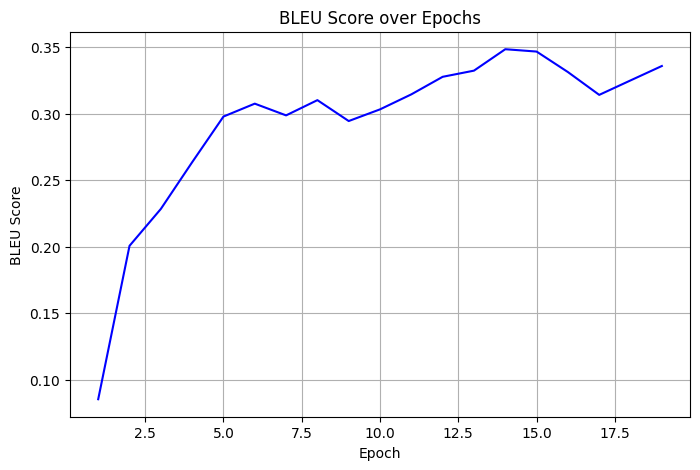

In [219]:
import matplotlib.pyplot as plt

epochs = [x['epoch'] for x in bleu_list]
bleu_scores = [x['bleu'] for x in bleu_list]

plt.figure(figsize=(8,5))
plt.plot(epochs, bleu_scores, linestyle='-', color='b')
plt.title("BLEU Score over Epochs")
plt.xlabel("Epoch")
plt.ylabel("BLEU Score")
plt.grid(True)
plt.show()

In [220]:
print(f"Bleu scores: {bleu_scores}")

Bleu scores: [0.08522801842820461, 0.2005561272497542, 0.2282820834477372, 0.26339652862981117, 0.2977319546930858, 0.30743576467789946, 0.29861769705983093, 0.3100736078359628, 0.2943646456090548, 0.30314305855776724, 0.3144253937857494, 0.3276165707898856, 0.3322488638018478, 0.3483545111292336, 0.34659182410747436, 0.3311940914168914, 0.31403035135131535, 0.3249061615939878, 0.33573629227368607]


In [234]:
seq2seq_model.eval()
smooth_fn = SmoothingFunction().method1
total_bleu = 0
num_samples = 0
results = []

for batch_inputs, batch_targets in test_loader:
    batch_inputs = batch_inputs[:, :max_seq_len].to(device)
    batch_targets = batch_targets[:, :max_seq_len].to(device)
    
    with torch.no_grad():
        encoder_outputs, hidden_cell = seq2seq_model.encoder(seq2seq_model.embedding(batch_inputs))
        hidden_cell = (hidden_cell[0].contiguous(), hidden_cell[1].contiguous())
        
        input_tok = batch_targets[:, 0]
        seq_len = batch_targets.size(1)
        generated_tokens = []

        for t in range(1, seq_len):
            output, hidden_cell = seq2seq_model.decoder(seq2seq_model.embedding(input_tok).unsqueeze(1), hidden_cell)
            output = seq2seq_model.fc(output.squeeze(1))
            pred_tok = output.argmax(dim=1)
            generated_tokens.append(pred_tok.unsqueeze(1))
            input_tok = pred_tok

        generated_tokens = torch.cat(generated_tokens, dim=1)

        # Compute BLEU per sample and save results
        for i in range(batch_targets.size(0)):
            ref = [itos[t.item()] for t in batch_targets[i] if t.item() not in (stoi["<pad>"],)]
            hyp = [itos[t.item()] for t in generated_tokens[i] if t.item() not in (stoi["<pad>"],)]
            
            if len(hyp) > 0 and len(ref) > 0:
                bleu_score = sentence_bleu([ref], hyp, smoothing_function=smooth_fn)
                total_bleu += bleu_score
                num_samples += 1

                results.append({
                    "source": "".join(ref),
                    "generated": "".join(hyp),
                    "target": "".join(ref),
                    "bleu": bleu_score
                })

# Convert results to DataFrame
df_results = pd.DataFrame(results)
avg_bleu = total_bleu / max(1, num_samples)
print(f"Test Set Average BLEU (char-level): {avg_bleu:.4f}")

# Optionally save to CSV
df_results.to_excel("test_results.xlsx", index=False)

Test Set Average BLEU (char-level): 0.4081


# 3. Steering Vector

In [224]:
# style_vector: mean hidden state for target style
hidden_states = []
for sentence in test_df['royal']:
    input_ids = torch.tensor([ [stoi[c] for c in sentence] ], device=device)
    with torch.no_grad():
        emb = seq2seq_model.embedding(input_ids)      # use the model's embedding
        _, hidden = seq2seq_model.encoder(emb)        # pass through LSTM
    hidden_states.append(hidden[0])


style_vector = torch.mean(torch.stack(hidden_states, dim=0), dim=0)  # [num_layers, 1, hidden_dim]

In [229]:
def tokenize_with_special(sentence, stoi):
    """
    Tokenizes a sentence, keeping <sos> and <eos> as single tokens.
    """
    tokens = []
    i = 0
    while i < len(sentence):
        if sentence[i:i+5] == "<sos>":
            tokens.append("<sos>")
            i += 5
        elif sentence[i:i+5] == "<eos>":
            tokens.append("<eos>")
            i += 5
        else:
            tokens.append(sentence[i])
            i += 1
    return [stoi[t] for t in tokens if t in stoi]

def generate_with_style_full(model, sentence, stoi, itos, style_vector, 
                             lambda_=0.1, max_len=100, device='cpu'):
    model.eval()
    with torch.no_grad():
        # Tokenize sentence properly
        token_ids = tokenize_with_special(sentence, stoi)
        src_ids = torch.tensor([token_ids], device=device)

        # Encoder forward (frozen)
        src_emb = model.embedding(src_ids)
        enc_outputs, enc_hidden = model.encoder(src_emb)

        # Decoder init
        input_tok = src_ids[:, 0]  # usually <sos>
        hidden = enc_hidden
        generated_ids = []

        for t in range(max_len):
            dec_emb = model.embedding(input_tok).unsqueeze(1)
            dec_out, hidden = model.decoder(dec_emb, hidden)

            # Inject style vector
            new_hidden = (hidden[0] + lambda_ * style_vector, hidden[1])
            hidden = new_hidden

            logits = model.fc(dec_out.squeeze(1))
            pred_tok = logits.argmax(dim=1)
            generated_ids.append(pred_tok.item())

            if pred_tok.item() == stoi.get("<eos>", -1):
                break

            input_tok = pred_tok

    generated_text = "".join([itos[i] for i in generated_ids])
    return generated_text



In [231]:
# Pre-computed style vector of shape [num_layers, 1, hidden_dim]
style_vector = torch.zeros(2, 1, 256, device=device)  

sentence = "ព្រះមហាក្សត្រប្រទានព្រះរាជទ្រព្យជួយរាស្"
generated_text = generate_with_style_full(
    model=seq2seq_model,
    sentence=sentence,
    stoi=stoi,
    itos=itos,
    style_vector=style_vector,
    lambda_=0.1,
    max_len=100,
    device=device
)
print("Generated:", generated_text)



Generated: ព្រះបិតារបស់ព្រះអង្គមានព្រះនាម នរោត្តម សីហនុ ដែ់ព្រះនាងសាន់<eos>
